In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -P 2019Deepfashion2** /content/drive/MyDrive/ECE1508\ DL\ Project/validation.zip  -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/validation/image/007349.jpg  
  inflating: /content/validation/image/007310.jpg  
  inflating: /content/validation/image/007286.jpg  
  inflating: /content/validation/image/007274.jpg  
  inflating: /content/validation/image/007218.jpg  
  inflating: /content/validation/image/007216.jpg  
  inflating: /content/validation/image/007204.jpg  
  inflating: /content/validation/image/007133.jpg  
  inflating: /content/validation/image/007081.jpg  
  inflating: /content/validation/image/007045.jpg  
  inflating: /content/validation/image/007044.jpg  
  inflating: /content/validation/image/007017.jpg  
  inflating: /content/validation/image/006960.jpg  
  inflating: /content/validation/image/006868.jpg  
  inflating: /content/validation/image/006831.jpg  
  inflating: /content/validation/image/006773.jpg  
  inflating: /content/validation/image/006744.jpg  
  inflating: /content/validation/image/006720.jpg  
  inflating: 

In [ ]:
!ls /content/validation/image -1 -R | wc -l

32154


## Dataframe

In [4]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

In [5]:
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm

root_dir = '/content/validation'
image_dir = os.path.join(root_dir, 'image')
annotation_dir = os.path.join(root_dir, 'annos')
image_files = os.listdir(image_dir)

def load_data(img_file):
    img_name = os.path.join(image_dir, img_file)
    annotation_name = os.path.join(annotation_dir, os.path.splitext(img_file)[0] + '.json')

    # Load image
    # image = Image.open(img_name).convert('RGB')

    # Load annotation
    with open(annotation_name) as f:
        annotation = json.load(f)

    # Extract specific keys and their nested values
    item1 = annotation.get('item1', {})
    item2 = annotation.get('item2', {})

    item1_category_name = item1.get('category_name', None)
    item1_scale = item1.get('scale', None)
    item1_bounding_box = item1.get('bounding_box', None)
    item1_category_id = item1.get('category_id', None)

    item2_category_name = item2.get('category_name', None)
    item2_scale = item2.get('scale', None)
    item2_bounding_box = item2.get('bounding_box', None)
    item2_category_id = item2.get('category_id', None)


    return {
            'image_file': img_file,
            # 'image_data': image,
            'item1_category_name': item1_category_name,
            'item1_scale': item1_scale,
            'item1_bounding_box': item1_bounding_box,
            'item1_category_id': item1_category_id,
            'item2_category_name': item2_category_name,
            'item2_scale': item2_scale,
            'item2_bounding_box': item2_bounding_box,
            'item2_category_id': item2_category_id}

# Create a pool of workers
num_workers = os.cpu_count()  # Use the number of CPU cores
with Pool(num_workers) as pool:
    data = list(tqdm(pool.imap(load_data, image_files), total=len(image_files)))

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Example:
print(df.head())  # Display the first few rows of the DataFrame


100%|██████████| 32153/32153 [00:19<00:00, 1666.44it/s]


   image_file item1_category_name  item1_scale    item1_bounding_box  \
0  006529.jpg   long sleeve dress            3    [0, 128, 467, 623]   
1  020684.jpg   long sleeve dress            2  [230, 181, 511, 699]   
2  027402.jpg     long sleeve top            3    [214, 2, 705, 536]   
3  024539.jpg    short sleeve top            1  [241, 236, 465, 422]   
4  029170.jpg    short sleeve top            2  [146, 280, 536, 777]   

   item1_category_id item2_category_name  item2_scale    item2_bounding_box  \
0                 11                None          NaN                  None   
1                 11                None          NaN                  None   
2                  2               skirt          2.0  [225, 351, 645, 568]   
3                  1              shorts          1.0  [262, 400, 447, 563]   
4                  1            trousers          2.0  [189, 702, 445, 995]   

   item2_category_id  
0                NaN  
1                NaN  
2                9.0  


### Drawing image with bbox

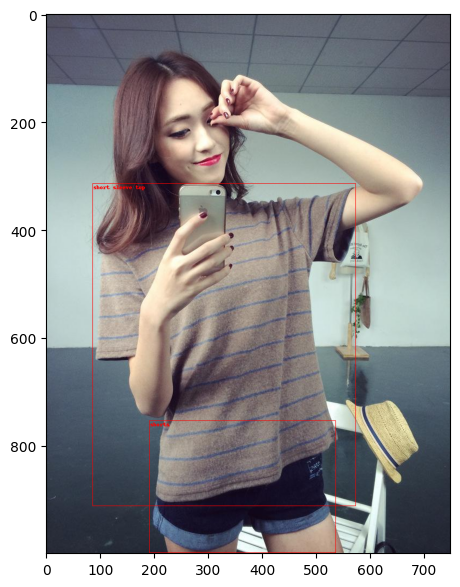

In [ ]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

test_image = Image.open('/content/validation/image/011239.jpg')

pred_labels = [f"{label}" for label in (['short sleeve top', 'shorts'])]
pred_boxes = torch.tensor([df.iloc[1]['item1_bounding_box'], df.iloc[1]['item2_bounding_box']])
image = torch.tensor(np.array(test_image)).permute(2, 0, 1)#.float()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(7, 7))
plt.imshow(output_image.permute(1, 2, 0))

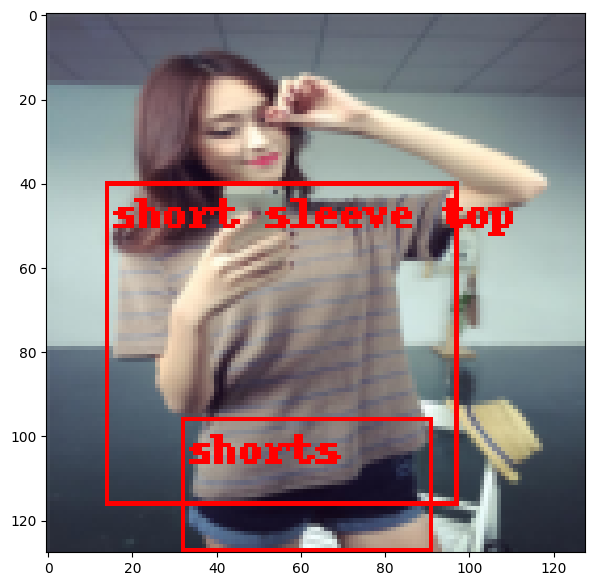

In [ ]:
df_copy = df.copy(deep=True)
pred_labels = [f"{label}" for label in (['short sleeve top', 'shorts'])]
bbox1 = df_copy.iloc[1]['item1_bounding_box']
bbox2 = df_copy.iloc[1]['item2_bounding_box']
RESIZE = 128;

img_w, img_h = test_image.size

for box in[bbox1, bbox2]:
  box[0] = box[0] / (img_w / RESIZE)
  box[1] = box[1] / (img_h / RESIZE)
  box[2] = box[2] / (img_w / RESIZE)
  box[3] = box[3] / (img_h / RESIZE)

resize_transform = transforms.Resize((RESIZE, RESIZE)) # Define the resize transform
test_img_resized = resize_transform(test_image)

pred_boxes = torch.tensor([bbox1, bbox2])
image = torch.tensor(np.array(test_img_resized)).permute(2, 0, 1)#.float()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(7, 7))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
df[:5000]['item1_category_name'].value_counts()

item1_category_name
short sleeve top        1480
long sleeve top          689
vest dress               460
short sleeve dress       454
trousers                 439
skirt                    324
vest                     275
long sleeve outwear      272
long sleeve dress        247
shorts                   189
sling dress              109
sling                     47
short sleeve outwear      15
Name: count, dtype: int64

In [ ]:
df['item1_category_name'].value_counts(normalize=True)

item1_category_name
short sleeve top        0.298666
long sleeve top         0.137281
short sleeve dress      0.094113
vest dress              0.093117
trousers                0.086835
skirt                   0.067054
vest                    0.054521
long sleeve outwear     0.052686
long sleeve dress       0.043635
shorts                  0.037322
sling dress             0.022580
sling                   0.008864
short sleeve outwear    0.003328
Name: proportion, dtype: float64

In [ ]:
df['item2_category_name'].value_counts(normalize=True)

item2_category_name
trousers                0.325697
skirt                   0.220761
shorts                  0.149314
short sleeve top        0.145411
long sleeve top         0.074323
sling dress             0.021265
vest                    0.018029
vest dress              0.017823
long sleeve outwear     0.015409
short sleeve dress      0.004623
long sleeve dress       0.003801
short sleeve outwear    0.001798
sling                   0.001746
Name: proportion, dtype: float64

In [ ]:
df[df['item2_category_name'].isna()].shape

(783, 9)

## Create a category vector (label)

In [6]:
item_categories = {}
unique_item1_categories = pd.DataFrame(df['item1_category_name'].unique())
unique_item2_categories = pd.DataFrame(df['item2_category_name'].unique())
unique_categories = pd.concat([unique_item1_categories, unique_item2_categories], axis=0)[0].unique()

for i in range(len(unique_categories)):
  if unique_categories[i] is None:
    item_categories[unique_categories[i]] = 0
  else:
    item_categories[unique_categories[i]] = i+1

def category_vector(categories):
  output = []
  for i in item_categories.keys():
    if i in categories:
      output.append(1)
    else:
      output.append(0)

  return output


In [7]:
item_categories

{'long sleeve dress': 1,
 'long sleeve top': 2,
 'short sleeve top': 3,
 'vest dress': 4,
 'trousers': 5,
 'skirt': 6,
 'short sleeve dress': 7,
 'sling': 8,
 'long sleeve outwear': 9,
 'sling dress': 10,
 'vest': 11,
 'shorts': 12,
 'short sleeve outwear': 13,
 None: 0}

## Create custom pytorch dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, image_resize=256):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'image')
        self.annotation_dir = os.path.join(root_dir, 'annos')
        # self.image_files = os.listdir(self.image_dir)
        self.image_files = os.listdir(self.image_dir)[:6000] #starting with smaller subset
        self.image_resize = image_resize

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        annotation_name = os.path.join(self.annotation_dir, os.path.splitext(self.image_files[idx])[0] + '.json')

        image = Image.open(img_name).convert('RGB')
        image_width, image_height = image.size

        with open(annotation_name) as f:
            annotation = json.load(f)

        # Extract specific keys and their nested values
        item1 = annotation.get('item1', {})
        item2 = annotation.get('item2', {})

        item1_category_name = item1.get('category_name', None)
        item1_bounding_box = item1.get('bounding_box', None)
        item1_bounding_box[0] = item1_bounding_box[0] / image_width * self.image_resize
        item1_bounding_box[1] = item1_bounding_box[1] / image_height * self.image_resize
        item1_bounding_box[2] = item1_bounding_box[2] / image_width * self.image_resize
        item1_bounding_box[3] = item1_bounding_box[3] / image_height * self.image_resize


        item2_category_name = item2.get('category_name', None)
        item2_bounding_box = item2.get('bounding_box', None)
        # item2_bounding_box[0] = item2_bounding_box[0] / image_width * self.image_resize
        # item2_bounding_box[1] = item2_bounding_box[1] / image_height * self.image_resize
        # item2_bounding_box[2] = item2_bounding_box[2] / image_width * self.image_resize
        # item2_bounding_box[3] = item2_bounding_box[3] / image_height * self.image_resize
        # For example, resizing images, normalizing, etc.
        if item2_bounding_box is not None:
          item2_bounding_box[0] = item2_bounding_box[0] / image_width * self.image_resize
          item2_bounding_box[1] = item2_bounding_box[1] / image_height * self.image_resize
          item2_bounding_box[2] = item2_bounding_box[2] / image_width * self.image_resize
          item2_bounding_box[3] = item2_bounding_box[3] / image_height * self.image_resize

          bbox = torch.tensor([item1_bounding_box, item2_bounding_box])
        else:
          bbox = torch.tensor([item1_bounding_box])


        resize_transform = transforms.Resize((self.image_resize, self.image_resize)) # Define the resize transform
        image = resize_transform(image)
        # print(image.shape)

        # Convert to tensors
        image = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        # annotation = torch.tensor(annotation)  # Assuming annotation is a dictionary or list
        # category = torch.tensor([category_vector([item1_category_name]), category_vector([item2_category_name])]) # A vector with binary values
        # category = torch.tensor([item_categories[item1_category_name], item_categories[item2_category_name]])
        # bbox = torch.tensor([item1_bounding_box, item2_bounding_box])

        if item2_category_name is not None:
          category =  torch.tensor([item_categories[item1_category_name], item_categories[item2_category_name]])
          # category = torch.tensor([category_vector([item1_category_name]), category_vector([item2_category_name])]) # A vector with binary values
        else:
          category = torch.tensor((item_categories[item1_category_name],))
          # category = torch.tensor(category_vector([item1_category_name]))
        # print(category_vector([item1_category_name, item2_category_name]))

        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        iscrowd = torch.zeros((len(self.image_files),), dtype=torch.int64)

        target = {}
        target['labels'] = category
        target['boxes'] = bbox
        target['image_id'] = idx
        target['area'] = area
        target['iscrowd'] = iscrowd
        return image, target

# Example usage:
dataset = CustomDataset('/content/validation')

## Dataset Split

In [9]:
import random

In [10]:
TEST_SIZE = 0.2
BATCH_SIZE = 8
SEED = 112
train_size = int(0.8 * len(dataset))

indices = list(range(len(dataset)))
random.seed(SEED)  # fix the seed so the shuffle will be the same everytime
random.shuffle(indices)
train_split = torch.utils.data.Subset(dataset, indices[:train_size])
test_split = torch.utils.data.Subset(dataset, indices[train_size:])

def collate_fn(batch):
    return tuple(zip(*batch))

# create batches
train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

# # TRAIN_BATCH_SIZE = 16
# TRAIN_BATCH_SIZE = 3

# train_data_loader = DataLoader(
#     dataset,
#     batch_size=TRAIN_BATCH_SIZE,
#     shuffle=False,
#     num_workers=1,
#     collate_fn=collate_fn
# )

# train_data_loader = DataLoader(
#     dataset,
#     batch_size=TRAIN_BATCH_SIZE,
#     shuffle=False,
#     num_workers=1,
#     collate_fn=collate_fn
# )

# RetinaNet

In [11]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import mobilenet_v2

backbone = mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 3 x 3 anchors per spatial
# location, with 3 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

model = RetinaNet(backbone,num_classes=14,anchor_generator=anchor_generator, detections_per_img=2, topk_candidates=10)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.5MB/s]


In [ ]:
import math
num_classes = len(item_categories) #+ 1
num_anchors = 9
out = model.head.classification_head.conv[3][0].out_channels

model = retinanet_resnet50_fpn(pretrained=True)
# replace classification layer
in_features = model.head.classification_head.conv[0][0].in_channels
model.head.classification_head.num_anchors = num_anchors
model.head.classification_head.num_classes = num_classes

cls_logits = torch.nn.Conv2d(out, num_anchors * num_classes, kernel_size = 3, stride=1, padding=1)
torch.nn.init.normal_(cls_logits.weight, std=0.01)  # as per pytorch code
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # as per pytorcch code
# assign cls head to model
model.head.classification_head.cls_logits = cls_logits

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# ONLY RUN ONCE

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RetinaNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e

In [ ]:
def get_iou(bb1, bb2):

    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0

    return iou

In [23]:
from torchvision.models.detection import RetinaNet
def test(model, dataloader, loss_function, device):
    # we first move our model to the configured device
    model = model.to(device = device)

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for test
    with torch.no_grad():
        risk = 0
        total_labels = 0
        correct_predict = 0


        # loop over test mini-batches
        for i, (images, targets) in enumerate(dataloader):

            images = list(image.to(device) for image in images)

            # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # labels = [t['labels'].to(device) for t in targets]
            labels = [t['labels'].to(device) for t in targets]
            boxes = [t['boxes'].to(device) for t in targets]


            # forward pass
            preds = model(images)
            outputs =[i['labels'] for i in preds]
            pred_boxes = [i['boxes'] for i in preds]


            for i in range(len(images)):
              correct_predict += (torch.isin(torch.unique(outputs[i]), torch.unique(labels[i])).sum())
              total_labels += (torch.unique(labels[i]).size(dim=0))

        test_accuracy = correct_predict/total_labels
        # test_avg_iou = iou_score/correct_predict

    return test_accuracy, correct_predict, total_labels #, test_avg_iou

In [14]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(
#     params,
#     lr=0.001
# )
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 5
loss_fn = torch.nn.BCELoss()
# torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    model.train()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
    train_one_epoch(model, optimizer, train_batches, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, test_batches, device=device)

    # model.eval()
    evaluate(model, test_batches, device=device)
    # acc, correct_predictions, total_labels = test(model, test_batches, loss_fn, device)
print(f'Done training.')
    # print(f'Epoch {epoch}: Classification Accuracy: {acc}  Correct label predictions: {correct_predictions}   Total true labels: {total_labels} ')

Epoch: [0]  [  0/600]  eta: 0:32:53  lr: 0.000013  loss: 4.6413 (4.6413)  classification: 1.1416 (1.1416)  bbox_regression: 3.4997 (3.4997)  time: 3.2886  data: 0.0963  max mem: 9110
Epoch: [0]  [100/600]  eta: 0:08:04  lr: 0.000847  loss: 2.5837 (3.0230)  classification: 0.6124 (0.8138)  bbox_regression: 1.9147 (2.2092)  time: 0.9691  data: 0.0667  max mem: 9770
Epoch: [0]  [200/600]  eta: 0:06:27  lr: 0.001681  loss: 2.3883 (2.7446)  classification: 0.5471 (0.7094)  bbox_regression: 1.8024 (2.0352)  time: 0.9709  data: 0.0663  max mem: 9770
Epoch: [0]  [300/600]  eta: 0:04:50  lr: 0.002515  loss: 2.1216 (2.5831)  classification: 0.5090 (0.6598)  bbox_regression: 1.5682 (1.9233)  time: 0.9696  data: 0.0656  max mem: 9770
Epoch: [0]  [400/600]  eta: 0:03:13  lr: 0.003349  loss: 2.0058 (2.4741)  classification: 0.4959 (0.6490)  bbox_regression: 1.5024 (1.8251)  time: 0.9667  data: 0.0649  max mem: 9770
Epoch: [0]  [500/600]  eta: 0:01:37  lr: 0.004183  loss: 1.8784 (2.3763)  classificat

In [17]:
torch.save(model.state_dict(), 'retinanet_model.pth')

In [18]:
!mv retinanet_model.pth /content/drive/MyDrive/ECE1508\ DL\ Project/

In [19]:
model.eval()
images, targets = next(iter(test_batches))
images = list(image.to(device) for image in images)
labels = [t['labels'].to('cpu') for t in targets]
boxes = [t['boxes'].to('cpu') for t in targets]
preds = model(images)  # Returns losses and detections


In [20]:
labels

[tensor([9, 6]),
 tensor([2, 6]),
 tensor([2, 6]),
 tensor([ 2, 10]),
 tensor([2, 5]),
 tensor([2]),
 tensor([3, 5]),
 tensor([3, 6])]

In [21]:
print(preds)

[{'boxes': tensor([[ 92.5391,  67.4194, 185.8693, 231.4940],
        [ 93.4001,  75.3442, 183.5047, 229.9745]], device='cuda:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.3321, 0.3306], device='cuda:0', grad_fn=<IndexBackward0>), 'labels': tensor([6, 4], device='cuda:0')}, {'boxes': tensor([[ 94.5108, 104.0882, 185.1148, 158.9878],
        [ 90.3265,  58.1047, 185.7215, 114.4384]], device='cuda:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.4880, 0.3563], device='cuda:0', grad_fn=<IndexBackward0>), 'labels': tensor([6, 3], device='cuda:0')}, {'boxes': tensor([[  0.0000,  10.8373, 255.9434, 238.8710],
        [  6.0251,  25.3263, 252.1567, 221.8095]], device='cuda:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.4146, 0.3925], device='cuda:0', grad_fn=<IndexBackward0>), 'labels': tensor([3, 6], device='cuda:0')}, {'boxes': tensor([[ 94.9175,  54.1904, 148.0309, 152.9850],
        [ 93.2081,  63.0756, 146.6747, 185.2220]], device='cuda:0',
       grad_fn=<

In [22]:
item_categories

{'long sleeve dress': 1,
 'long sleeve top': 2,
 'short sleeve top': 3,
 'vest dress': 4,
 'trousers': 5,
 'skirt': 6,
 'short sleeve dress': 7,
 'sling': 8,
 'long sleeve outwear': 9,
 'sling dress': 10,
 'vest': 11,
 'shorts': 12,
 'short sleeve outwear': 13,
 None: 0}

In [ ]:
out_labels = [o['labels'] for o in preds]
print(out_labels)
out_boxes = [o['boxes'] for o in preds]
print(out_boxes)

[tensor([3, 3], device='cuda:0'), tensor([6, 3], device='cuda:0'), tensor([3], device='cuda:0'), tensor([6, 4], device='cuda:0'), tensor([3], device='cuda:0'), tensor([5, 3], device='cuda:0'), tensor([5], device='cuda:0'), tensor([3], device='cuda:0')]
[tensor([[40.0630, 27.8821, 80.8812, 93.5849],
        [54.1049, 10.3745, 88.2471, 56.2302]], device='cuda:0',
       grad_fn=<StackBackward0>), tensor([[39.6274, 44.4097, 83.1058, 68.9407],
        [39.7957, 24.6761, 79.8481, 49.6284]], device='cuda:0',
       grad_fn=<StackBackward0>), tensor([[  0.0000,  15.9350, 100.5315, 112.0000]], device='cuda:0',
       grad_fn=<StackBackward0>), tensor([[40.0818, 32.9634, 66.9070, 81.9373],
        [41.0634, 24.7117, 64.2701, 81.1336]], device='cuda:0',
       grad_fn=<StackBackward0>), tensor([[ 16.6881,  27.5206, 101.8803,  90.1130]], device='cuda:0',
       grad_fn=<StackBackward0>), tensor([[ 2.8205, 11.1222, 95.9220, 66.8957],
        [28.6882, 13.7976, 99.2940, 65.5118]], device='cuda:0',


### Drawing Bounding Box and Image


In [ ]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

NameError: name 'read_image' is not defined